In [ ]:
### Throw this on Google Colab
### Make sure to set Runtime to "GPU" --- even with the free version there should not be any issues, otherwise some experiments will take a while.

In [1]:
!pip install pykeops > install.log

import pykeops

###necessary because of a "deprecated" issue in the pykeops code that obstructs the output in the experiments below
###if you're ok with seeing these come up, you can comment out the this line
pykeops.set_verbose(False)

###necessary imports
import numpy as np
import torch
from scipy import linalg
from scipy.linalg import sqrtm, inv, det
from math import *
from numpy.random import multivariate_normal as mvn


import matplotlib.pyplot as plt
import statsmodels.api as sm
import matplotlib
from matplotlib.lines import Line2D

import pickle
import time

from functools import partial

#####
# Code here is taken from: https://gitlab.com/proussillon/wasserstein-estimation-sinkhorn-divergence with some small modifications
##### 
try:  # Import the keops library, www.kernel-operations.io
    from pykeops.torch import generic_logsumexp
    from pykeops.torch import generic_sum
    from pykeops.torch import Genred
    keops_available = True
except:
    keops_available = False
    
#Use gpu if available
use_cuda = torch.cuda.is_available()
dtype    = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
dtypeint = torch.cuda.LongTensor if use_cuda else torch.LongTensor

def log_weights(α):
    α_log = α.log()
    α_log[α <= 0] = -100000
    return α_log

def sinkhorn_loop( softmin, marg_x, α_log, β_log, C_xy, C_yx, ε, Nits_max = None,tol=5*10**(-6)):
#sinkhorn_loop performs the Sinkhorn iterations until convergence.
    Nits = 1
    N, D = C_xy[0].shape
    M, D = C_xy[1].shape
    # Start with a decent initialization for the dual vectors:
    v = softmin(ε, C_yx, α_log )  # OT(α,β) wrt. a
    u = softmin(ε, C_xy, β_log )  # OT(α,β) wrt. b
    
    err = (torch.abs(marg_x(ε, C_yx, v, u)/N-1.)).sum()/M
    err_marginal = [err]

    if Nits_max == None:
        Nits_max = 5*10**3

    while (Nits< Nits_max) and (err > tol or Nits < 2 ):
        Nits += 1
        # "Coordinate ascent" on the dual problems:
        v = softmin(ε, C_yx, α_log + u/ε )  # OT(α,β) wrt. a
        u = softmin(ε, C_xy, β_log + v/ε )  # OT(α,β) wrt. b
        if Nits % 50 == 0:
          err = (torch.abs(marg_x(ε, C_yx, v, u)/N-1.)).sum()/M
          err_marginal.append(err)
    #print(Nits)
    u_t, v_t = u, v
    return u_t, v_t

def T(blur, alpha, x, beta, y, sym=False,Nits_max=None,keops_available = keops_available,tol=5*10**(-6)):
        
    n, d = x.shape
    Loss =  loss_sinkhorn_online(d, p=2, blur=blur, sym=sym,Nits_max = Nits_max, keops_available = keops_available,tol=tol)
    u_ab, v_ab = Loss( alpha, x, beta, y )
            
    return u_ab, v_ab

# ==============================================================================
#                          backend == "tensorized"
# ==============================================================================

def squared_distances(x, y):
    D_xx = (x*x).sum(-1).unsqueeze(1)  # (N,1)
    D_xy = torch.matmul( x, y.permute(1,0) )  # (N,D) @ (D,M) = (N,M)
    D_yy = (y*y).sum(-1).unsqueeze(0)  # (1,M)
    return D_xx - 2*D_xy + D_yy

def softmin_tensorized():
    def softmin(ε, C_xy, g):
        x, y = C_xy
        return - ε * ( g[None,:] - squared_distances(x,y)/ε ).logsumexp(1).view(-1)
    return softmin

def lse_tensorized():
    def lse(ε,C_xy,g):
        x,y = C_xy
        return ( g[None,:] - squared_distances(x,y)/ε ).logsumexp(1).view(-1)
    return lse

def marginal_tensorized():
    #print("Tensorized version")
    def marginal(ε, C_xy, u, v):
        x, y = C_xy
        marginal_i = torch.exp( (u[:,None] + v[None,:] - squared_distances(x,y))/ε ).sum(dim = 1)
        return marginal_i
    return marginal

# ==============================================================================
#                          backend == "online"
# ==============================================================================

cost_formulas = {
    1 : "Norm2(X-Y)",
    2 : "(SqDist(X,Y))",
}

def softmin_online(ε, C_xy, f_y, log_conv=None):
    x, y = C_xy
    # KeOps is pretty picky on the input shapes...
    return - ε * log_conv( x, y, f_y.view(-1,1), torch.Tensor([1/ε]).type_as(x) ).view(-1)

def lse_online(ε,C_xy, f_y, log_conv=None):
    x, y = C_xy
    # KeOps is pretty picky on the input shapes...
    return log_conv( x, y, f_y.view(-1,1), torch.Tensor([1/ε]).type_as(x) ).view(-1)

def marginal_online(ε, C_xy, b_x, a_y, log_conv=None):
    x,y = C_xy
    
    return log_conv( torch.Tensor([1/ε]).type_as(x), x, y, b_x.view(-1,1), a_y.view(-1,1) )


def keops_OT_plan(D, dtype="float32"):
        
    OT_plan = Genred('Exp( (F_i + G_j - SqDist(X_i,Y_j)) * E )', # F(g,x,y,b) = exp( -g*|x-y|^2 ) * b
                       ['E = Pm(1)',          # First arg  is a parameter,    of dim 1
                        'X_i = Vi({})'.format(D),          # Second arg is indexed by "i", of dim 3
                        'Y_j = Vj({})'.format(D),          # Third arg  is indexed by "j", of dim 3
                        'F_i = Vi(1)',  # 4th arg: one scalar value per line
                        'G_j = Vj(1)'],         # Fourth arg is indexed by "j", of dim 2
                       reduction_op='Sum',
                       axis=1)                # Summation over "j"

    return OT_plan

def keops_lse(cost, D, dtype="float32"):
    log_conv = generic_logsumexp("( B - (P * " + cost + " ) )",
                                 "A = Vi(1)",
                                 "X = Vi({})".format(D),
                                 "Y = Vj({})".format(D),
                                 "B = Vj(1)",
                                 "P = Pm(1)",
                                 dtype = dtype)
    return log_conv



def loss_sinkhorn_online(dim, p=2, blur =.05, sym=False,Nits_max=None, acceleration = False, keops_available = True,tol=5*10**(-6)):
    
    cost = cost_formulas[p]
    
    if keops_available:
        softmin = partial( softmin_online, log_conv = keops_lse(cost, dim, dtype="float32") ) 
        marg_x = partial( marginal_online, log_conv = keops_OT_plan(dim, dtype="float32" ) )
        lse_ = partial( lse_online, log_conv=keops_lse(cost,dim,dtype="float32"))

    else:
        softmin = softmin_tensorized()
        marg_x = marginal_tensorized()
        lse_ = lse_tensorized()

    def loss(α, x, β, y):
        # The "cost matrices" are implicitely encoded in the point clouds,
        # and re-computed on-the-fly
        C_xy, C_yx = ( (x, y.detach()), (y, x.detach()) )
        u, v = sinkhorn_loop(softmin, marg_x, log_weights(α), log_weights(β),C_xy, C_yx, blur, Nits_max = Nits_max,tol=tol)
        return u,v

    return loss

#########################
### OT map estimators ###
#########################
def T_epsn(x,yz,v,blur):
    M = squared_distances(x,yz)
    K = -M/blur + v/blur
    gammaz = -torch.max(K,dim=1)[0]
    K_shift = K + gammaz.reshape(-1,1)
    exp_ = torch.exp(K_shift)
    top_ = torch.matmul(exp_ ,yz)
    bot_ = exp_.sum(axis=1)
    fast = top_.T/bot_
    return fast

###debiased estimator
def T_D_epsn(x,xz,yz,v,v_mu,blur):
    ot_mu = T_epsn(x, xz, v_mu, blur)
    ot_est = T_epsn(x, yz, v, blur)
    ot_debiased = ot_est + (x.T - ot_mu)
    return ot_debiased

[KeOps] Compiling cuda jit compiler engine ... OK
[pyKeOps] Compiling nvrtc binder for python ... OK


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
###Gaussian to Gaussian transport Source and Target generation

def sampling_gaussians(A,B):#sampling Gaussian densities with covariances A and B, both have mean zero
    sqrtA, sqrtB = linalg.sqrtm( A ), linalg.sqrtm( B )
    InvsqrtA, InvsqrtB =  linalg.inv( sqrtA ), linalg.inv( sqrtB )
    transport_plan = InvsqrtA @ linalg.sqrtm( sqrtA @ B @ sqrtA ) @ InvsqrtA
    def generate_samples_gaussians(n,d):
        x_np = np.random.multivariate_normal(np.zeros(d), A, n)
        y_np = (transport_plan @ (x_np.T)).T
        x = torch.from_numpy(x_np).type(dtype)
        y = torch.from_numpy(y_np).type(dtype)
        return 1/n*torch.ones(x.shape[0]).type(dtype), x, 1/n*torch.ones(y.shape[0]).type(dtype), y.contiguous()
    return generate_samples_gaussians


### closed form Entropic Map expressions
def Sigma_eps(S,eps):
    dim=len(S)
    return -np.eye(dim)*(eps/2) + sqrtm( (eps**2)/4 * np.eye(dim) + S )
def Tdb(S,eps):
    dim=len(S)
    t2 = sqrtm( (eps**2)/4 * np.eye(dim) + S )
    t3 = sqrtm( (eps**2)/4 * np.eye(dim) + np.eye(dim) )
    return np.eye(dim) + t2 - t3

In [3]:
######plotting utils#######
matplotlib.rcParams.update({'font.size': 13})
def CreateEpsComparePlot_G2GMSE(file,ylimz=None,save=False):
    with open(file, 'rb') as f:
        file1 = pickle.load(f)

    L2_biased=file1['L2_biased_Error']
    L2_debiased=file1['L2_debiased_Error']
    Es = file1['Es']
    Ns = file1['Ns']
    dim = file1['dim']
    data = file1['data']
    factor = file1['factor']
    B = file1['targetcov']
    print(np.linalg.eigvals(B))


    ##### closed form lines
    eps_range = np.linspace(min(Es),max(Es),150)
    map_errs_b  = np.zeros((len(eps_range),1))
    map_errs_db = np.zeros((len(eps_range),1))
    N_MC = 50000
    for k, lbd in enumerate(eps_range):
        source = mvn(mean=np.zeros(dim),cov=np.eye(dim),size=N_MC)
        target = (sqrtm(B)@source.T).T
        S_eps = Sigma_eps(B,lbd)
        I_eps = Sigma_eps(np.eye(dim),lbd)
        Tb = (S_eps@ source.T).T
        Tdb = Tb + ((np.eye(dim) - I_eps)@source.T).T

        map_errs_b[k] = (np.linalg.norm(Tb - target,axis=1)**2).mean()
        map_errs_db[k] = (np.linalg.norm(Tdb - target,axis=1)**2).mean()
    #####
    
    title='finite_estimation_G2G_dim_{}_factor{}'.format(dim,factor)
    fig = plt.plot(figsize=(6, 5))
    x = np.array(Es)
    c1='#377eb8' ###biased
    c2='#ff7f00' ###debiased
    linez = ['dashed','dotted','solid']

    for i,n in enumerate(Ns):
        li = linez[i]
        y_b = L2_biased[:,i,:]
        y_db = L2_debiased[:,i,:]
        ###compute the means across the trials
        y_b_means = np.mean(y_b,axis=-1)
        y_db_means = np.mean(y_db,axis=-1)
        ###compute the standard deviation across trials
        y_b_stds = np.std(y_b,axis=-1)
        y_db_stds = np.std(y_db,axis=-1)
        x_ = sm.add_constant(np.log(np.array(Es)))
        ###plotting MSE of estimators
        plt.loglog(x,y_b_means,c=c1,linestyle=li,linewidth=1.5)
        plt.loglog(x,y_db_means,c=c2,linestyle=li,linewidth=2.5)
        ###plotting error bars on logscale too
        plt.errorbar(x,y_b_means,yerr=y_b_stds,c=c1,linestyle=li,linewidth=1.5)
        plt.errorbar(x,y_db_means,yerr=y_db_stds,c=c2,linestyle=li,linewidth=2.5)
    
    ###plotting closed-form MSE values
    plt.loglog(eps_range,map_errs_b,c=c1,linestyle='solid',linewidth=1.5)
    plt.loglog(eps_range,map_errs_db,c=c2,linestyle='solid',linewidth=2.5)
    ###ylimz are useful for cropping unecessary whitespace in the plots created by default
    if ylimz != None:
        plt.ylim(ylimz)
    plt.xlabel('$\epsilon$')
    plt.ylabel('MSE')
    plt.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)

    lines = [Line2D([0], [0], color='black',linestyle=li, linewidth=2.5) for li in linez]
    labels = ['N = {:.0e}'.format(Ns[0]), 'N = {:.0e}'.format(Ns[1]), 'N = $\infty$']
    plt.legend(lines, labels)

    if save:
        savename = title+'.pdf'
        plt.savefig(savename,bbox_inches='tight')

The following code blocks run the experiments from Section 5.2 of the paper

*Parameters and their meaning*

- N_sampling: # samples for Monte Carlo integration
- Ns: # samples to learn the maps from, needs to be a list of length 2
- numTrials: # of trials to repeat the procedure and generate error bars
- Es: regularization parameter, should be a list with several numbers
- dim: dimension of the problem 
- data: always 'g2g' for this notebook
- Nits_max: max number of iterations for Sinkhorn's algorithm above
- factor: important for generating covariance matrices that are "concentrated" or "spread out" (note that this constant should scale with dimension)

[1.4457551 3.5542449]
eps=5.000000, n=1000, trials: 15/15, time=16
eps=5.000000, n=10000, trials: 15/15, time=23
==== Done 5.000000 epsilon level ====
eps=4.000000, n=1000, trials: 15/15, time=25
eps=4.000000, n=10000, trials: 15/15, time=32
==== Done 4.000000 epsilon level ====
eps=3.000000, n=1000, trials: 15/15, time=34
eps=3.000000, n=10000, trials: 15/15, time=40
==== Done 3.000000 epsilon level ====
eps=2.000000, n=1000, trials: 15/15, time=43
eps=2.000000, n=10000, trials: 15/15, time=49
==== Done 2.000000 epsilon level ====
eps=1.000000, n=1000, trials: 15/15, time=52
eps=1.000000, n=10000, trials: 15/15, time=58
==== Done 1.000000 epsilon level ====
eps=0.700000, n=1000, trials: 15/15, time=61
eps=0.700000, n=10000, trials: 15/15, time=68
==== Done 0.700000 epsilon level ====
eps=0.500000, n=1000, trials: 15/15, time=71
eps=0.500000, n=10000, trials: 15/15, time=79
==== Done 0.500000 epsilon level ====
eps=0.100000, n=1000, trials: 15/15, time=93
eps=0.100000, n=10000, trials:

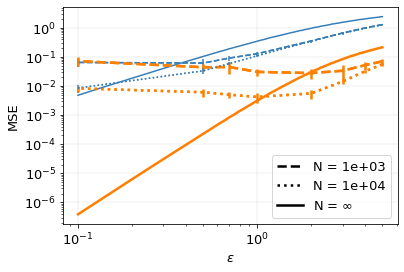

In [4]:
##### Gaussian to Gaussian transportation problem ######
N_sampling = 50000
Ns = [1000,10000]
numTrials = 15
#Es = [1,0.7,0.50,0.1,0.07,0.05]
Es = [5,4,3,2,1,0.7,0.50,0.1]
dim = 2 ###dimension of the problem
data = 'g2g' ###dataset of choice
Nits_max = 1000
tol = 5*10**(-6)
keops=True

###generate random covariance matrix
factor=5
A = np.eye(dim)
M_ = np.random.randn(dim,3*dim)
B_ = M_@M_.T
trB_ = np.trace(B_)/factor
B = B_/trB_
generate_samples_g2g = sampling_gaussians(A,B)
print(np.linalg.eigvals(B))


L2_biased_Error = np.zeros( (len(Es), len(Ns), numTrials))
L2_debiased_Error = np.zeros( (len(Es), len(Ns), numTrials))

tstart=time.time()
for k, lbd in enumerate(Es): ###loop through "Es"
    for i, n in enumerate(Ns): ###loop through "Ns" of size two
        for t in range(numTrials):
              
            ###generate ``training" data and "L^2(P) estimation data"
            alpha, x, beta, _ = generate_samples_g2g(n,dim)
            _, _, _, y = generate_samples_g2g(n,dim)
            alpha2, x2, beta2, ot_t = generate_samples_g2g(N_sampling,dim)

            t0 = time.time()
            u_ab, v_ab = T(lbd, alpha, x, beta, y, Nits_max=Nits_max,keops_available = keops,tol=tol)
            u_aa, v_aa = T(lbd, alpha, x, alpha, x, Nits_max=Nits_max,keops_available = keops,tol=tol)

            t_biased = T_epsn(x2,y,v_ab,lbd)
            t_debiased = T_D_epsn(x2, x, y, v_ab, v_aa, lbd)

            ###compute L^2(P) between T and T_eps, and T and T^D_\eps
            L2_biased_Error[k,i,t] = (torch.linalg.norm( (ot_t.T - t_biased),dim=0)**2).mean()
            L2_debiased_Error[k,i,t] = (torch.linalg.norm( (ot_t.T - t_debiased),dim=0)**2).mean()

            if (t+1)%numTrials == 0:
                print('eps=%f, n=%d, trials: %d/%d, time=%d'%(lbd, n,t+1, numTrials, time.time()-tstart))
    print('==== Done %f epsilon level ===='%(lbd))


dic = {'targetcov': B, 'Es': Es, 'dim': dim, 'N_sampling': N_sampling, 'Ns': Ns, 'numTrials': numTrials,
        'L2_biased_Error': L2_biased_Error, 'L2_debiased_Error': L2_debiased_Error, 'factor':factor,
         'data': data, 'keops' :keops, 'cuda':use_cuda}

pkl_title = '{}-D-{}_error_factor{}.pkl'.format(dim,data,factor)
output = open(pkl_title,'wb')
pickle.dump(dic,output)
output.close()

CreateEpsComparePlot_G2GMSE('{}-D-{}_error_factor{}.pkl'.format(dim,data,factor),save=True)

[2.80764642 2.32193818 2.38532834 2.01936238 1.64437873 0.30578571
 0.42768189 1.45530955 1.35205479 1.19961313 1.05651903 0.86277568
 0.63567289 0.78462509 0.74130819]
eps=7.000000, n=1000, trials: 15/15, time=4
eps=7.000000, n=10000, trials: 15/15, time=17
==== Done 7.000000 epsilon level ====
eps=5.000000, n=1000, trials: 15/15, time=20
eps=5.000000, n=10000, trials: 15/15, time=32
==== Done 5.000000 epsilon level ====
eps=1.000000, n=1000, trials: 15/15, time=40
eps=1.000000, n=10000, trials: 15/15, time=89
==== Done 1.000000 epsilon level ====
eps=0.700000, n=1000, trials: 15/15, time=101
eps=0.700000, n=10000, trials: 15/15, time=134
==== Done 0.700000 epsilon level ====
eps=0.500000, n=1000, trials: 15/15, time=155
eps=0.500000, n=10000, trials: 15/15, time=198
==== Done 0.500000 epsilon level ====
eps=0.100000, n=1000, trials: 15/15, time=219
eps=0.100000, n=10000, trials: 15/15, time=295
==== Done 0.100000 epsilon level ====
[2.80764642 2.32193818 2.38532834 2.01936238 1.64437

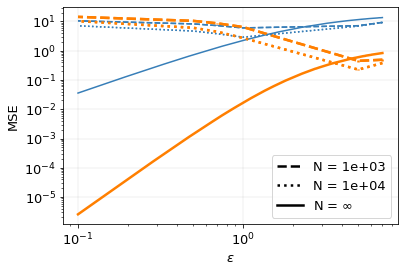

In [5]:
##### Gaussian to Gaussian transportation problem ######
N_sampling = 50000
Ns = [1000,10000]
numTrials = 15
Es = [7,5,1,0.7,0.50,0.1]
dim = 15 ###dimension of the problem
data = 'g2g' ###dataset of choice
Nits_max = 1000
tol = 5*10**(-6)
keops=True

###generate random covariance matrix
factor=20
A = np.eye(dim)
M_ = np.random.randn(dim,3*dim)
B_ = M_@M_.T
trB_ = np.trace(B_)/factor
B = B_/trB_
generate_samples_g2g = sampling_gaussians(A,B)
print(np.linalg.eigvals(B))


L2_biased_Error = np.zeros( (len(Es), len(Ns), numTrials))
L2_debiased_Error = np.zeros( (len(Es), len(Ns), numTrials))
tstart=time.time()
for k, lbd in enumerate(Es): ###loop through "Es"
    for i, n in enumerate(Ns): ###loop through "Ns" of size two
        for t in range(numTrials):
              
            ###generate ``training" data and "L^2(P) estimation data"
            alpha, x, beta, _ = generate_samples_g2g(n,dim)
            _, _, _, y = generate_samples_g2g(n,dim)
            alpha2, x2, beta2, ot_t = generate_samples_g2g(N_sampling,dim)

            t0 = time.time()
            u_ab, v_ab = T(lbd, alpha, x, beta, y, Nits_max=Nits_max,keops_available = keops,tol=tol)
            u_aa, v_aa = T(lbd, alpha, x, alpha, x, Nits_max=Nits_max,keops_available = keops,tol=tol)

            t_biased = T_epsn(x2,y,v_ab,lbd)
            t_debiased = T_D_epsn(x2, x, y, v_ab, v_aa, lbd)

            ###compute L^2(P) between T and T_eps, and T and T^D_\eps
            L2_biased_Error[k,i,t] = (torch.linalg.norm( (ot_t.T - t_biased),dim=0)**2).mean()
            L2_debiased_Error[k,i,t] = (torch.linalg.norm( (ot_t.T - t_debiased),dim=0)**2).mean()

            if (t+1)%numTrials == 0:
                print('eps=%f, n=%d, trials: %d/%d, time=%d'%(lbd, n,t+1, numTrials, time.time()-tstart))
    print('==== Done %f epsilon level ===='%(lbd))


dic = {'targetcov': B, 'Es': Es, 'dim': dim, 'N_sampling': N_sampling, 'Ns': Ns, 'numTrials': numTrials,
        'L2_biased_Error': L2_biased_Error, 'L2_debiased_Error': L2_debiased_Error, 'factor':factor,
         'data': data, 'keops' :keops, 'cuda':use_cuda}

pkl_title = '{}-D-{}_error_factor{}.pkl'.format(dim,data,factor)
output = open(pkl_title,'wb')
pickle.dump(dic,output)
output.close()

CreateEpsComparePlot_G2GMSE('{}-D-{}_error_factor{}.pkl'.format(dim,data,factor),save=True)

[2.80764642 2.32193818 2.38532834 2.01936238 1.64437873 0.30578571
 0.42768189 1.45530955 1.35205479 1.19961313 1.05651903 0.86277568
 0.63567289 0.78462509 0.74130819]


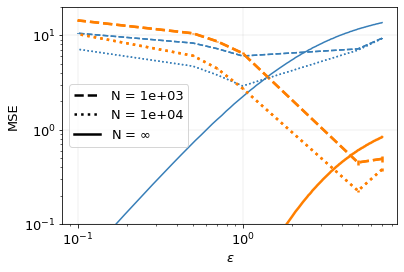

In [6]:
CreateEpsComparePlot_G2GMSE('{}-D-{}_error_factor{}.pkl'.format(15,data,20),ylimz=[1e-1,2e+1],save=True)